TO DO LIST:
- check if the reverse-scaling is needed
- check the warning
- how to see it in the map?

In [1]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt

In [3]:
from pystac_client import Client
from odc.stac import load
import odc.geo

In [4]:
# use publically available stac link such as
client = Client.open("https://earth-search.aws.element84.com/v1") 

# ID of the collection
collection = "sentinel-2-l2a"

# Geometry of AOI
geometry = {
    "coordinates": [
        [
            [74.66218437999487, 19.46556170905807],
            [74.6629598736763, 19.466339343697722],
            [74.6640371158719, 19.4667885366414],
            [74.66395296156406, 19.46614872872264],
            [74.66376889497042, 19.466150941501425],
            [74.66369077563286, 19.46577508478787],
            [74.6635865047574, 19.465278788212864],
            [74.66282073408365, 19.46540270444271],
            [74.66218437999487, 19.46556170905807],
        ]
    ],
    "type": "Polygon",
}

here there are different ways to select the images 

In [6]:
# Specific Date
date_YYMMDD = "2024-01-21"
# run pystac client search to see available dataset
search = client.search(
    collections=[collection], intersects=geometry, datetime=date_YYMMDD
)
# spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())


{'type': 'FeatureCollection', 'features': []}


In [9]:
# Date range
date_range = "2023-01-10/2023-01-20"
# run pystac client search to see available dataset
search = client.search(
    collections=[collection], intersects=geometry, datetime=date_range
)
# spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())
# loop through each item
for item in search.items_as_dicts():
    print(item)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2A_43QDB_20230119_0_L2A', 'properties': {'created': '2023-01-19T11:37:28.671Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 0.000146, 'proj:epsg': 32643, 'mgrs:utm_zone': 43, 'mgrs:latitude_band': 'Q', 'mgrs:grid_square': 'DB', 'grid:code': 'MGRS-43QDB', 'view:sun_azimuth': 150.170643299269, 'view:sun_elevation': 44.673952419329, 's2:degraded_msi_data_percentage': 0.0001, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0, 's2:cloud_shadow_percentage': 0, 's2:vegetation_percentage': 23.361552, 's2:not_vegetated_percentage': 75.508511, 's2:water_percentage': 1.128812, 's2:unclassified_percentage': 0.000985, 's2:medium_proba_clouds_percentage': 0, 's2:high_proba_clouds_percentage': 0, 's2:thin_cirrus_percentage': 0.000146, 's2:snow_ice_percentage': 0, 's2:product_type': 'S2MSI2A

In [15]:
# additional filters as per metadata 
filters = {
    "eo:cloud_cover":{"lt":0.2},
    "s2:vegetation_percentage": {"gt": 25}
}
date_YYMM = "2023-01"
# run pystac client search to see available dataset 
search = client.search(collections=[collection], intersects=geometry , query=filters ,datetime=date_YYMM) #bbox=tas_bbox
#spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())
# loop through each item
for item in search.items_as_dicts():
    print(item)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2A_43QDB_20230109_0_L2A', 'properties': {'created': '2023-01-09T13:41:20.389Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 0.000664, 'proj:epsg': 32643, 'mgrs:utm_zone': 43, 'mgrs:latitude_band': 'Q', 'mgrs:grid_square': 'DB', 'grid:code': 'MGRS-43QDB', 'view:sun_azimuth': 152.409883529928, 'view:sun_elevation': 43.5651505036477, 's2:degraded_msi_data_percentage': 0.0001, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0, 's2:cloud_shadow_percentage': 0.006662, 's2:vegetation_percentage': 32.694611, 's2:not_vegetated_percentage': 66.053742, 's2:water_percentage': 1.243841, 's2:unclassified_percentage': 0.000484, 's2:medium_proba_clouds_percentage': 1e-05, 's2:high_proba_clouds_percentage': 7e-06, 's2:thin_cirrus_percentage': 0.000647, 's2:snow_ice_percentage': 0, 's2:product

This is where odc-stac will be helpful, it converts data into xarray Dataset


In [11]:
#load the data in xarray format
data = load(search.items() ,geopolygon=geometry,groupby="solar_day", chunks={})
print(data)

<xarray.Dataset> Size: 24kB
Dimensions:       (y: 18, x: 20, time: 1)
Coordinates:
  * y             (y) float64 144B 2.153e+06 2.153e+06 ... 2.152e+06 2.152e+06
  * x             (x) float64 160B 4.645e+05 4.646e+05 ... 4.647e+05 4.647e+05
    spatial_ref   int32 4B 32643
  * time          (time) datetime64[ns] 8B 2023-01-09T05:43:37.058000
Data variables: (12/32)
    aot           (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    blue          (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    coastal       (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    green         (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    nir           (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    nir08         (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    ...            ...
    rededge3-jp2  (time, y, x) uint16 720B da

In [17]:
data.data_vars

Data variables:
    aot           (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    blue          (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    coastal       (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    green         (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    nir           (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    nir08         (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    nir09         (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    red           (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    rededge1      (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    rededge2      (time, y, x) uint16 720B dask.array<chunksize=(1, 18, 20), meta=np.ndarray>
    rededge3      (time, y, x) uint16 720B d

In [20]:
def getstuff(band,prop):
  return search.item_collection_as_dict()['features'][0]['assets'][band]['raster:bands'][0][prop]

data['ndvi'] = ( 
    (data["nir"] * getstuff('nir', 'scale') + getstuff('nir', 'offset')) 
    -  
    (data["red"] * getstuff('red', 'scale') + getstuff('red', 'offset'))
    )/(
    (data["nir"] * getstuff('nir', 'scale') + getstuff('nir', 'offset'))
    +  
    (data["red"] * getstuff('red', 'scale') + getstuff('red', 'offset'))
    )

In [21]:
# create the index without considering scale or offset
#ndvi = (data.nir - data.red) / (data.nir + data.red)
ndvi = data['ndvi']

In [22]:
# this represent the entire bounding box
odc.geo.xr.write_cog(ndvi,fname='ndvi.tiff',  overwrite=True)

PosixPath('ndvi.tiff')

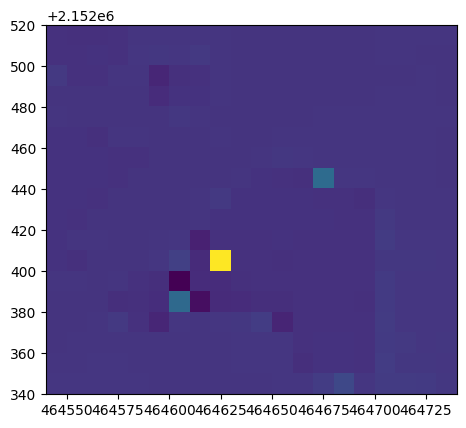

<Axes: >

In [24]:
img = rasterio.open("./ndvi.tiff")
show(img)

you can use GDAL or rasterio to reproject the tiff to EPSG:4326 ( In which we have our original geometry)

In [25]:
# Add Imports
from osgeo import gdal
import rasterio as rio
from rasterio import mask as msk

# Reproject file to EPSG:4326
input_file = f"ndvi.tiff"
# Path to save the reprojected GeoTIFF file
output_file = f"ndvi_reprojected.tiff"
# Define the target CRS (EPSG:4326)
dst_crs = 'EPSG:4326'
input_raster = gdal.Open(input_file)
warp = gdal.Warp(output_file, input_raster, dstSRS=dst_crs)


# Open reprojected raster
raster = rio.open(output_file)
# Use masking from rasterio to clip according to geometry
with raster as src:
    out_image, out_transform = msk.mask(src, [geometry], crop=True)
    out_meta = src.meta.copy()
    out_meta.update(
        {
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": 0,
        }
    )
# set new file path
farmpath = f"final_ndvi.tiff"
# Export newly created raster
with rio.open(farmpath, "w", **out_meta) as dest:
    dest.write(out_image)
    dest.close()

Warning 1: ndvi_reprojected.tiff: TIFFReadDirectory:Bogus "StripByteCounts" field, ignoring and calculating from imagelength


Warning 1: TIFFReadDirectory:Bogus "StripByteCounts" field, ignoring and calculating from imagelength


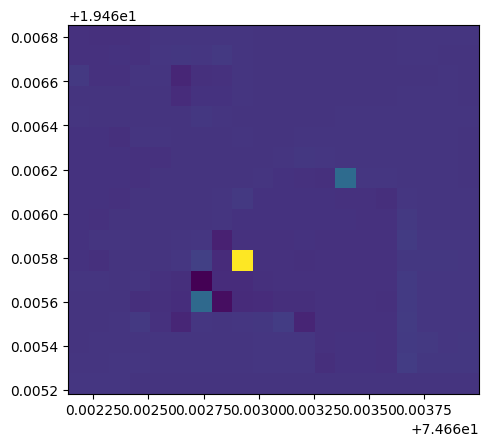

<Axes: >

In [26]:
img = rasterio.open("./ndvi_reprojected.tiff")
show(img)